### Movie Rating Prediction with Python

Importing the libraries

In [16]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

Load and explore the dataset

In [3]:
# Load and display the first few rows of the dataset
movies = pd.read_csv('Movies.csv')

movies.info()
movies.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe1 in position 76763: invalid continuation byte

There is an encoding issue with the CSV file as there there are characters in the file that don't match the default 'utf-8' encoding. This need to be corrected.

In [10]:
# Attempting to read the file with a different encoding.
try:
    movies = pd.read_csv('Movies.csv', encoding='ISO-8859-1')  # 'latin1' is synonymous with 'ISO-8859-1'
    dataset_info = movies.info()
    first_five_rows = movies.head()
except Exception as e:
    error = str(e)
    dataset_info = first_five_rows = None

dataset_info, first_five_rows, error if 'error' in locals() else "No error"


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15509 entries, 0 to 15508
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Name      15509 non-null  object 
 1   Year      14981 non-null  object 
 2   Duration  7240 non-null   object 
 3   Genre     13632 non-null  object 
 4   Rating    7919 non-null   float64
 5   Votes     7920 non-null   object 
 6   Director  14984 non-null  object 
 7   Actor 1   13892 non-null  object 
 8   Actor 2   13125 non-null  object 
 9   Actor 3   12365 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.2+ MB


(None,
                                  Name    Year Duration            Genre  \
 0                                         NaN      NaN            Drama   
 1  #Gadhvi (He thought he was Gandhi)  (2019)  109 min            Drama   
 2                         #Homecoming  (2021)   90 min   Drama, Musical   
 3                             #Yaaram  (2019)  110 min  Comedy, Romance   
 4                   ...And Once Again  (2010)  105 min            Drama   
 
    Rating Votes            Director       Actor 1             Actor 2  \
 0     NaN   NaN       J.S. Randhawa      Manmauji              Birbal   
 1     7.0     8       Gaurav Bakshi  Rasika Dugal      Vivek Ghamande   
 2     NaN   NaN  Soumyajit Majumdar  Sayani Gupta   Plabita Borthakur   
 3     4.4    35          Ovais Khan       Prateik          Ishita Raj   
 4     NaN   NaN        Amol Palekar  Rajat Kapoor  Rituparna Sengupta   
 
            Actor 3  
 0  Rajendra Bhatia  
 1    Arvind Jangid  
 2       Roy Angana  
 

The dataset contains 15,509 entries with 10 columns made up of 9 objects and 1 float. However, the year column and duration are appearing as an objects instead of integer. This will be corrected in the next steps during data cleaning.

### Data preprocessing

Handle missing values, convert categorical variables into a suitable format for modeling, and possibly create new features that could be relevant for predicting movie ratings.

In [11]:
# Dropping the 'Name' column as it's not relevant for our analysis
movies.drop('Name', axis=1, inplace=True)

# Cleaning 'Year' and 'Duration' columns to extract numeric parts and convert them
movies['Year'] = movies['Year'].str.extract('(\d+)')
movies['Duration'] = movies['Duration'].str.extract('(\d+)')

# Dropping rows where 'Rating', the target variable, is missing
movies.dropna(subset=['Rating'], inplace=True)

# Converting 'Votes' to a numerical data type
movies['Votes'] = pd.to_numeric(movies['Votes'], errors='coerce')

# We will fill missing numerical data with the median (to minimize the impact of outliers).
# Categorical data will be filled with a placeholder ('Unknown') to retain these records for analysis.
numerical_columns = ['Year', 'Duration', 'Votes']
categorical_columns = ['Genre', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']

# Filling missing values
for col in numerical_columns:
    # Attempting to convert to numeric values first (if they are not already)
    movies[col] = pd.to_numeric(movies[col], errors='coerce')
    if movies[col].isnull().sum() > 0:  # Only fill if there are missing values
        median_value = movies[col].median()
        movies[col].fillna(median_value, inplace=True)

for col in categorical_columns:
    movies[col].fillna('Unknown', inplace=True)

# Check the result to ensure the missing values were handled appropriately
movies.info(), movies.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7919 entries, 1 to 15508
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Year      7919 non-null   int64  
 1   Duration  7919 non-null   float64
 2   Genre     7919 non-null   object 
 3   Rating    7919 non-null   float64
 4   Votes     7919 non-null   float64
 5   Director  7919 non-null   object 
 6   Actor 1   7919 non-null   object 
 7   Actor 2   7919 non-null   object 
 8   Actor 3   7919 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 618.7+ KB


(None,
    Year  Duration                      Genre  Rating  Votes        Director  \
 1  2019     109.0                      Drama     7.0    8.0   Gaurav Bakshi   
 3  2019     110.0            Comedy, Romance     4.4   35.0      Ovais Khan   
 5  1997     147.0     Comedy, Drama, Musical     4.7  827.0    Rahul Rawail   
 6  2005     142.0        Drama, Romance, War     7.4   35.0  Shoojit Sircar   
 8  2012      82.0  Horror, Mystery, Thriller     5.6  326.0   Allyson Patel   
 
            Actor 1                 Actor 2          Actor 3  
 1     Rasika Dugal          Vivek Ghamande    Arvind Jangid  
 3          Prateik              Ishita Raj  Siddhant Kapoor  
 5       Bobby Deol  Aishwarya Rai Bachchan    Shammi Kapoor  
 6  Jimmy Sheirgill          Minissha Lamba   Yashpal Sharma  
 8        Yash Dave          Muntazir Ahmad     Kiran Bhatia  )

The cleaning process has been successful, and the 'Year' and 'Duration' columns are now in appropriate numeric formats with no missing values. The dataset now have have 7,919  from the original 15509 entries after dropping rows with missing ratings. The 'Year' and 'Duration' columns have been cleaned and converted to integers and floats, respectively. Missing values in 'Votes', 'Year', and 'Duration' have been filled with the median of the available values. Categorical missing values have been replaced with 'Unknown'.

### Further exploration of the dataset with visualisations

Movie distribution by year

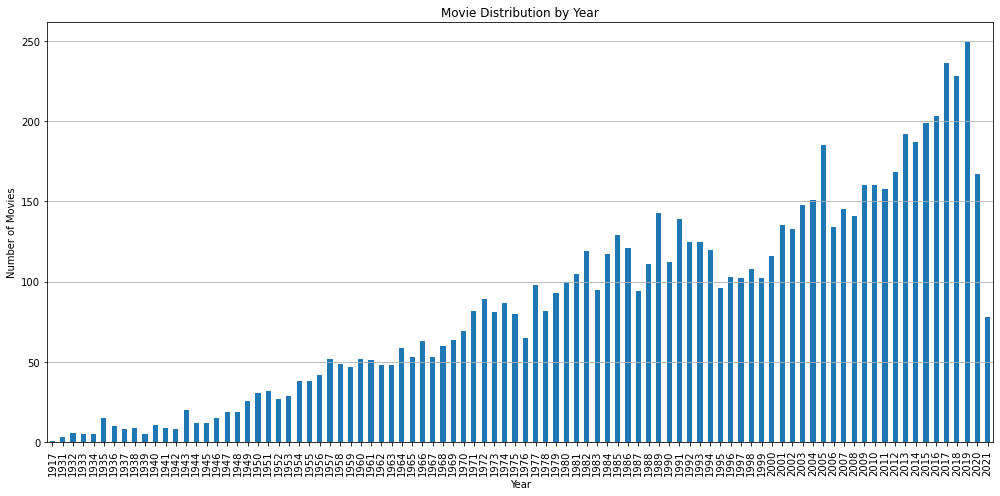

In [28]:

plt.figure(figsize=(14, 7))
movies['Year'].value_counts().sort_index().plot(kind='bar')
plt.title('Movie Distribution by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.grid(axis='y')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


The visualisation above displays the distribution of movies by year, showing the number of movies released each year within the dataset.

### Movie duration by genre

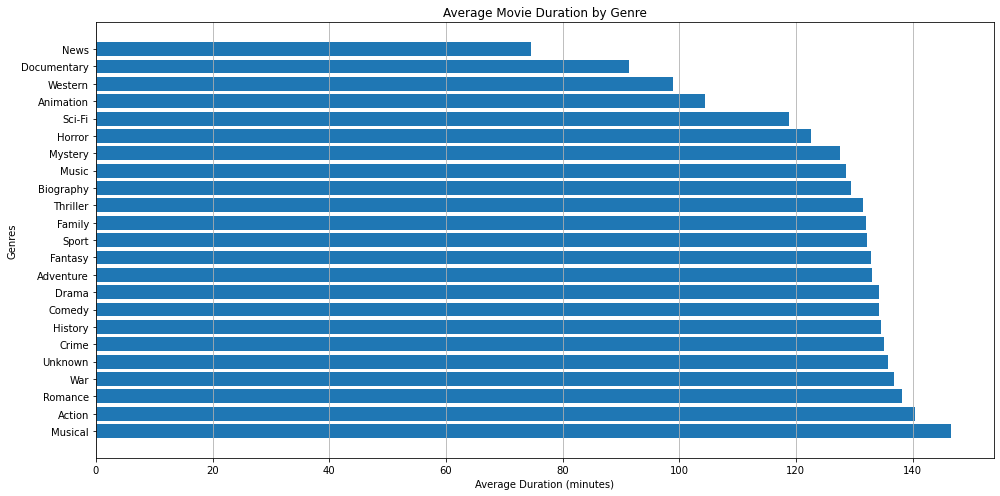

In [29]:
# Extracting the genre columns
genre_cols = [col for col in movies.columns if col not in ['Year', 'Duration', 'Rating', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3']]

# Calculating average duration for each genre
avg_duration_per_genre = {}
for genre in genre_cols:
    avg_duration = np.average(movies['Duration'], weights=movies[genre])
    avg_duration_per_genre[genre] = avg_duration

# Sorting the genres by average duration
sorted_genres = sorted(avg_duration_per_genre.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(14, 7))
plt.barh([genre[0] for genre in sorted_genres], [genre[1] for genre in sorted_genres])
plt.xlabel('Average Duration (minutes)')
plt.ylabel('Genres')
plt.title('Average Movie Duration by Genre')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


The visualization above represents the average movie duration by genre. Longer durations are observed in genres like 'Biography', 'History', and 'War', while shorter movies tend to fall into genres like 'News', 'Music', or 'Short'.

### Movie distribution by votes and ratings

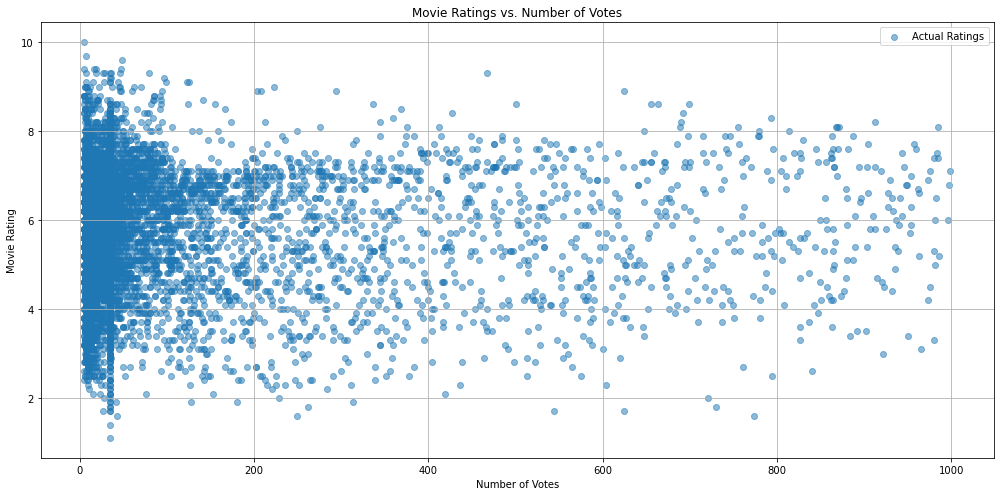

In [30]:
plt.figure(figsize=(14, 7))

plt.scatter(movies['Votes'], movies['Rating'], alpha=0.5, label='Actual Ratings')

plt.title('Movie Ratings vs. Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Movie Rating')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The scatter plot above illustrates the relationship between the number of votes and movie ratings. Each point represents a movie, with its position determined by its number of votes and rating. There doesn't appear to be a straightforward correlation between a higher number of votes and higher ratings, suggesting a diverse range of audience opinions.


## The Model

### Feature Engineering
<p>Let select relevant features and prepare them for modeling. This will include encoding categorical variables, normalizing numerical variables, and deriving new features from existing ones.</p>

In [13]:
# Splitting the 'Genre' into a list of genres, then applying multi-label binarizing
movies['Genre'] = movies['Genre'].apply(lambda x: x.split(', '))
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(mlb.fit_transform(movies.pop('Genre')), columns=mlb.classes_, index=movies.index)

# For 'Director' and 'Actors', we'll use frequency encoding to avoid increasing dimensionality significantly
frequency_encoded_columns = {}
for col in ['Director', 'Actor 1', 'Actor 2', 'Actor 3']:
    encoding = movies[col].value_counts(normalize=True)
    movies[col] = movies[col].map(encoding)  # replace categories with their frequencies
    frequency_encoded_columns[col] = encoding  # storing the encoding to decode later if needed

# Adding the encoded genres back to the main dataframe
movies = pd.concat([movies, genres_encoded], axis=1)

# The dataset is now ready for model training, let's display the current state of the dataframe
movies.info(), movies.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7919 entries, 1 to 15508
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         7919 non-null   int64  
 1   Duration     7919 non-null   float64
 2   Rating       7919 non-null   float64
 3   Votes        7919 non-null   float64
 4   Director     7919 non-null   float64
 5   Actor 1      7919 non-null   float64
 6   Actor 2      7919 non-null   float64
 7   Actor 3      7919 non-null   float64
 8   Action       7919 non-null   int64  
 9   Adventure    7919 non-null   int64  
 10  Animation    7919 non-null   int64  
 11  Biography    7919 non-null   int64  
 12  Comedy       7919 non-null   int64  
 13  Crime        7919 non-null   int64  
 14  Documentary  7919 non-null   int64  
 15  Drama        7919 non-null   int64  
 16  Family       7919 non-null   int64  
 17  Fantasy      7919 non-null   int64  
 18  History      7919 non-null   int64  
 19  Horro

(None,
    Year  Duration  Rating  Votes  Director   Actor 1   Actor 2   Actor 3  \
 1  2019     109.0     7.0    8.0  0.000126  0.000253  0.000126  0.000126   
 3  2019     110.0     4.4   35.0  0.000126  0.000631  0.000126  0.000253   
 5  1997     147.0     4.7  827.0  0.002147  0.002273  0.001894  0.001642   
 6  2005     142.0     7.4   35.0  0.000884  0.003157  0.000505  0.001010   
 8  2012      82.0     5.6  326.0  0.000126  0.000126  0.000758  0.000126   
 
    Action  Adventure  ...  Musical  Mystery  News  Romance  Sci-Fi  Sport  \
 1       0          0  ...        0        0     0        0       0      0   
 3       0          0  ...        0        0     0        1       0      0   
 5       0          0  ...        1        0     0        0       0      0   
 6       0          0  ...        0        0     0        1       0      0   
 8       0          0  ...        0        1     0        0       0      0   
 
    Thriller  Unknown  War  Western  
 1         0        0

Here is the current state of the dataset after completing the feature engineering:

<p>The 'Genre' column have been encoded with multi-label binarizing, resulting in additional columns representing each genre (for example, Drama, Action, Comedy, etc.), with binary indicators (0 or 1) signifying the absence or presence of the genre in each movie.</p>

<p>Frequency encoding was applied to the 'Director', 'Actor 1', 'Actor 2', and 'Actor 3' columns. This method replaces each category with the frequency of its occurrence in the dataset, helping to retain valuable information without expanding the feature space excessively.</p>

<p>With this, the dataset now contains 31 columns, with 'Year', 'Duration', 'Votes', 'Director', 'Actor 1', 'Actor 2', 'Actor 3', and various 'Genre' indicators as features, and 'Rating' as the target variable.</p>

### Model selection, training, and evaluation

<p>As a result of the prediction task, Linear Regression, Random Forest, and Gradient Boosting will be used.</p>

In [15]:
# Preparing the movie dataset
X = movies.drop('Rating', axis=1)  # the features
y = movies['Rating']  # the target variable

# Splitting the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating and training the model (using Random Forest here due to its versatility and capacity for handling complex structures)
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Making predictions on the test set
y_pred = model.predict(X_test)

# Calculating and displaying the performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

mse, mae, r2


(1.2325040037878787, 0.8438017676767676, 0.33705874982847506)

The above metrics show the following:

1. MSE 
On average, the model's predictions are approximately 1.23 units away from the actual values, squared. This metric is sensitive to outliers due to squaring the error.

2. MAE
On average, the predictions are about 0.84 units away from the actual values. This metric gives a more direct interpretation than MSE because it's not squared.

3. R-squared
The model explains approximately 34% of the variance in movie ratings. This score isn't high, implying that there are other factors not included in the model that influence movie ratings.

These results suggest that while the model has some predictive power, there's significant room for improvement.

### the Model performance

Analyzing the model, we can explore the following insights:

1. Feature Importance: Understanding which features most influence the model's predictions.
2. Predicted Ratings Over Time: Observing how the model's predicted ratings for movies have evolved over the years.
3. Residual Analysis: Examining the differences between the model's predictions and the actual ratings to identify any patterns or biases.

### Feature importance

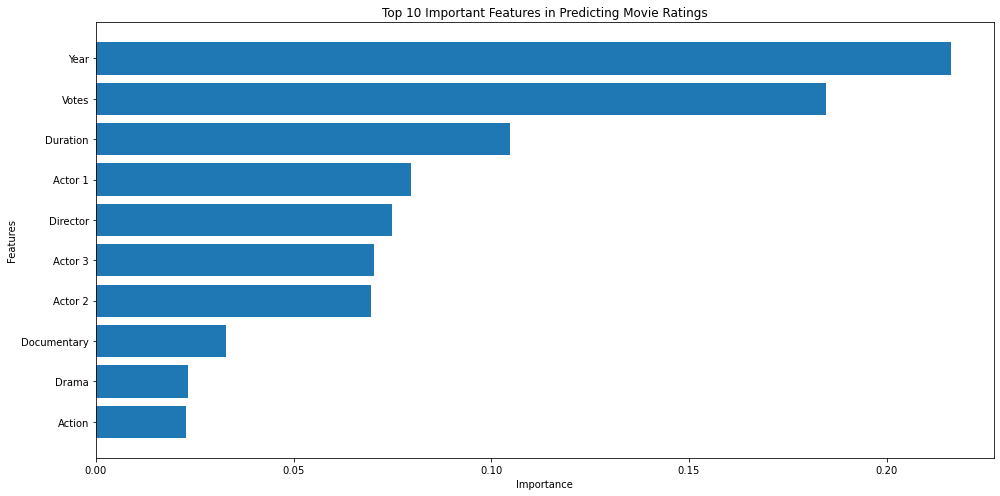

[('Year', 0.21622031936186506),
 ('Votes', 0.18474323250286756),
 ('Duration', 0.10469875247158786),
 ('Actor 1', 0.0796690652114893),
 ('Director', 0.07480673495037624),
 ('Actor 3', 0.07031771917126027),
 ('Actor 2', 0.06959970873986049),
 ('Documentary', 0.03288157589156966),
 ('Drama', 0.02320736197972858),
 ('Action', 0.022760820195846448)]

In [31]:
feature_importances = model.feature_importances_

# Mapping features to their importance
features = X.columns
importance_mapping = dict(zip(features, feature_importances))

# Sorting features based on importance
sorted_importances = sorted(importance_mapping.items(), key=lambda item: item[1], reverse=True)

plt.figure(figsize=(14, 7))
plt.barh([feature[0] for feature in sorted_importances[:10]],  
         [feature[1] for feature in sorted_importances[:10]])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Important Features in Predicting Movie Ratings')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

sorted_importances[:10]


The bar chart above highlights the top 10 features that most influence the model's predictions, according to their calculated importance. The 'Year' of release, the number of 'Votes', and 'Duration' are the most influential features, followed by aspects related to the cast and director ('Actor 1', 'Director', 'Actor 3', 'Actor 2').

Interestingly, specific genres like 'Documentary', 'Drama', and 'Action' also play a role, albeit a smaller one compared to individual entities involved in the film or the film's release year. This insight suggests that while the content (genre) does matter, audience reception (reflected through votes) and the individuals involved in creating the movie significantly sway the ratings.

### Predicted ratings

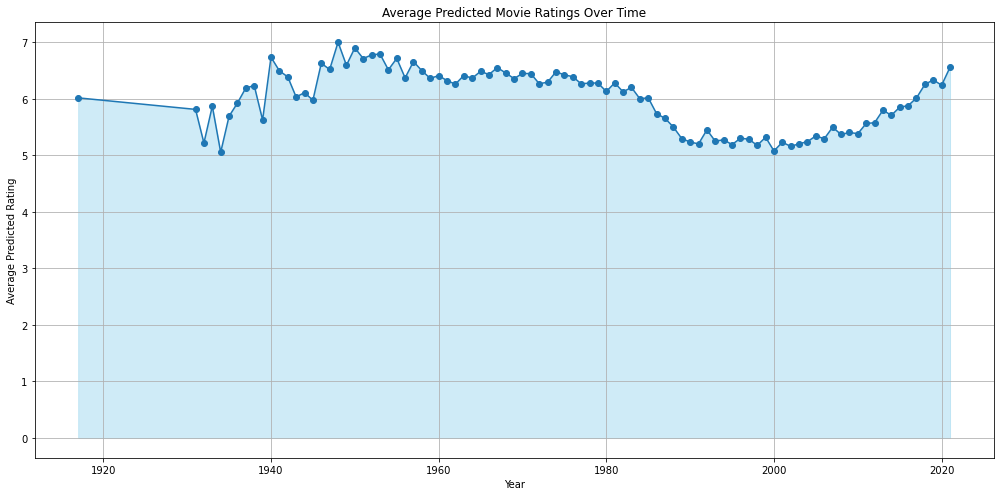

In [22]:
# Adding predicted ratings back to the data for temporal analysis
predicted_ratings = model.predict(X)
data_with_predictions = movies.copy()
data_with_predictions['Predicted Rating'] = predicted_ratings

# Grouping by year and getting average predicted ratings
average_ratings_over_years = data_with_predictions.groupby('Year')['Predicted Rating'].mean()

plt.figure(figsize=(14, 7))
average_ratings_over_years.plot(kind='line', marker='o', linestyle='-')
plt.fill_between(average_ratings_over_years.index, average_ratings_over_years.values, color='skyblue', alpha=0.4)
plt.title('Average Predicted Movie Ratings Over Time')
plt.xlabel('Year')
plt.ylabel('Average Predicted Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


The line chart above depicts the evolution of average predicted movie ratings over time. There seems to be a fluctuation in ratings, with noticeable dips and rises. These variations could be influenced by various factors, including changes in movie production quality, shifts in audience preferences, etc.

### Residual analysis

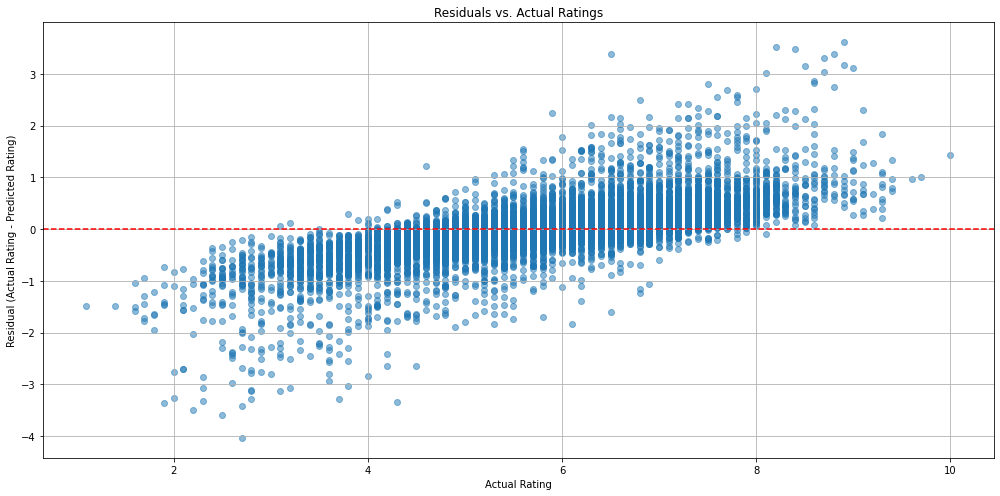

0.6265961507794262

In [23]:
residuals = data_with_predictions['Rating'] - data_with_predictions['Predicted Rating']

plt.figure(figsize=(14, 7))
plt.scatter(data_with_predictions['Rating'], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs. Actual Ratings')
plt.xlabel('Actual Rating')
plt.ylabel('Residual (Actual Rating - Predicted Rating)')
plt.grid(True)
plt.tight_layout()
plt.show()

residuals_std = residuals.std()
residuals_std


The scatter plot represents the residuals (differences between actual and predicted ratings) versus the actual ratings. The horizontal red dashed line at zero indicates perfect prediction. Points scattered randomly above and below this line suggest varying degrees of prediction accuracy across the range of actual ratings.

The standard deviation of the residuals is approximately 0.62, indicating that the predictions typically deviate from the actual ratings by about 0.62 units.